In [8]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import ParameterGrid
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
df = pd.read_excel('GS2.xlsx')
df.sample(2)

,Year,Question
161,2015,Discuss the possible factors that inhibit Indi...
150,2016,"“In the Indian governance system, the role of\..."


In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import re
import string

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    
    question_words = {'explain', 'what', 'when', 'where', 'who', 'whom', 'which', 'why', 'how', 
                        'comment', 'discuss','following', 'example', 
                        'examine', 'state', 'critically','context', 'measures', 
                        'suggest', 'evaluate', 'describe', 'identify', 'illustrate','can','could','should',
                        'do','does','would','did','will','might'}
    stop_words.update(question_words)
    stop_words = list(stop_words)
    
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' +', ' ', text)
    
    text = word_tokenize(text)
    filtered_sentence = [w for w in text if not w in stop_words]
    text = ' '.join(filtered_sentence)
    
    def lemmatize_sentence(sentence):
        nltk_tagged = pos_tag(nltk.word_tokenize(sentence))
        
        def nltk2wn_tag(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:          
                return None
    
        wordnet_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        return " ".join(lemmatized_sentence)
    return lemmatize_sentence(text)
    

In [12]:
text = df.Question[0]
print(text)
filtered_text = preprocess(text)
print(filtered_text)

“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.
constitutionally guarantee judicial independence prerequisite democracy


In [13]:
def bert_model(df):
    questions = df['Question'].values.tolist()
    lemmatized_questions = [preprocess(question) for question in questions]
    
    param_grid = {
        'n_gram_range': [(1, 2), (1, 3)],
        'questions': [lemmatized_questions, questions],
        'embedding_model': ['all-mpnet-base-v2', 'all-MiniLM-L6-v2','xlm-r-bert-base-nli-stsb-mean-tokens','distilbert-multilingual-nli-stsb-quora-ranking'],
        'diversity':[0.1,0.2,0.3],
    }
    
    best_params = None
    best_outliers = float('inf')
    outliers_list = []
    
    iteration = 0
    for params in ParameterGrid(param_grid):
        iteration+=1
        print(f"Iteration: {iteration}")
        print(params)
        
        sentence_model = SentenceTransformer(params['embedding_model'])
        ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)
        representation = [PartOfSpeech("en_core_web_sm"),MaximalMarginalRelevance(diversity=params['diversity']),KeyBERTInspired(top_n_words=30)]
        
        model = BERTopic(embedding_model=sentence_model,representation_model=representation,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics=7, n_gram_range=params['n_gram_range'], min_topic_size=10)
        topics, probs = model.fit_transform(params['questions'])
        
        unique_topics = len(set(topics)) - (1 if -1 in topics else 0)
        
        if unique_topics < 4 :
            continue
        
        outliers_count  = sum(1 for topic in topics if topic == -1)
        outliers_list.append(outliers_count)
        print(f"Outliers: {outliers_count}")
        
        if(outliers_count > 60):
            continue
        
        if(outliers_count < best_outliers):
            best_outliers = outliers_count
            best_params = params
            print(f"Best Outliers: {best_outliers}, Best Params: {best_params}")
            model.save('gs2_model')
            if(best_outliers < 20):
                break

In [14]:
bert_model(df)

Iteration: 1
{'diversity': 0.1, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light statem

2024-09-01 10:16:11,878 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
2024-09-01 10:16:20,133 - BERTopic - Embedding - Completed ✓
2024-09-01 10:16:20,134 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:16:31,191 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:16:31,194 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:16:31,243 - BERTopic - Cluster - Completed ✓
2024-09-01 10:16:31,245 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:16:37,128 - BERTopic - Representation - Completed ✓
2024-09-01 10:16:37,129 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:16:37,131 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 2
{'diversity': 0.1, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse o

2024-09-01 10:16:45,067 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]
2024-09-01 10:16:59,605 - BERTopic - Embedding - Completed ✓
2024-09-01 10:16:59,606 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:17:07,175 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:17:07,178 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:17:07,222 - BERTopic - Cluster - Completed ✓
2024-09-01 10:17:07,224 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:17:10,613 - BERTopic - Representation - Completed ✓
2024-09-01 10:17:10,615 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:17:10,618 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 3
{'diversity': 0.1, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light statem

2024-09-01 10:17:15,896 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
2024-09-01 10:17:23,939 - BERTopic - Embedding - Completed ✓
2024-09-01 10:17:23,940 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:17:31,063 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:17:31,065 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:17:31,099 - BERTopic - Cluster - Completed ✓
2024-09-01 10:17:31,101 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:17:34,154 - BERTopic - Representation - Completed ✓
2024-09-01 10:17:34,155 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:17:34,157 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 4
{'diversity': 0.1, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse o

2024-09-01 10:17:40,319 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]
2024-09-01 10:17:54,743 - BERTopic - Embedding - Completed ✓
2024-09-01 10:17:54,743 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:18:01,617 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:18:01,619 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:18:01,648 - BERTopic - Cluster - Completed ✓
2024-09-01 10:18:01,650 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:18:04,957 - BERTopic - Representation - Completed ✓
2024-09-01 10:18:04,958 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:18:04,960 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 5
{'diversity': 0.1, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light stateme

2024-09-01 10:18:10,085 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]
2024-09-01 10:18:12,220 - BERTopic - Embedding - Completed ✓
2024-09-01 10:18:12,220 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:18:18,993 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:18:18,995 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:18:19,018 - BERTopic - Cluster - Completed ✓
2024-09-01 10:18:19,019 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:18:21,343 - BERTopic - Representation - Completed ✓
2024-09-01 10:18:21,344 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:18:21,346 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


Iteration: 6
{'diversity': 0.1, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse of

2024-09-01 10:18:26,252 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]
2024-09-01 10:18:29,914 - BERTopic - Embedding - Completed ✓
2024-09-01 10:18:29,915 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:18:40,362 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:18:40,363 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:18:40,389 - BERTopic - Cluster - Completed ✓
2024-09-01 10:18:40,391 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:18:43,469 - BERTopic - Representation - Completed ✓
2024-09-01 10:18:43,470 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:18:43,472 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 7
{'diversity': 0.1, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light stateme

2024-09-01 10:18:48,638 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]
2024-09-01 10:18:50,735 - BERTopic - Embedding - Completed ✓
2024-09-01 10:18:50,736 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:18:57,393 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:18:57,395 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:18:57,426 - BERTopic - Cluster - Completed ✓
2024-09-01 10:18:57,428 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:19:00,854 - BERTopic - Representation - Completed ✓
2024-09-01 10:19:00,854 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:19:00,858 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 71
Iteration: 8
{'diversity': 0.1, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing

2024-09-01 10:19:06,549 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]
2024-09-01 10:19:09,934 - BERTopic - Embedding - Completed ✓
2024-09-01 10:19:09,935 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:19:16,447 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:19:16,448 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:19:16,471 - BERTopic - Cluster - Completed ✓
2024-09-01 10:19:16,473 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:19:18,759 - BERTopic - Representation - Completed ✓
2024-09-01 10:19:18,761 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:19:18,763 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


Iteration: 9
{'diversity': 0.1, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect functi

2024-09-01 10:19:32,215 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it]
2024-09-01 10:19:41,945 - BERTopic - Embedding - Completed ✓
2024-09-01 10:19:41,945 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:19:49,185 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:19:49,187 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:19:49,233 - BERTopic - Cluster - Completed ✓
2024-09-01 10:19:49,234 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:19:59,684 - BERTopic - Representation - Completed ✓
2024-09-01 10:19:59,684 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:19:59,687 - BERTopic - Topic reduction - Reduced number of topics from 7 to 7


Outliers: 126
Iteration: 10
{'diversity': 0.1, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission 

2024-09-01 10:20:10,322 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it]
2024-09-01 10:20:27,773 - BERTopic - Embedding - Completed ✓
2024-09-01 10:20:27,774 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:20:34,898 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:20:34,900 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:20:34,933 - BERTopic - Cluster - Completed ✓
2024-09-01 10:20:34,933 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:20:43,423 - BERTopic - Representation - Completed ✓
2024-09-01 10:20:43,424 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:20:43,426 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 68
Iteration: 11
{'diversity': 0.1, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict

2024-09-01 10:20:55,951 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
2024-09-01 10:21:05,174 - BERTopic - Embedding - Completed ✓
2024-09-01 10:21:05,174 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:21:12,354 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:21:12,355 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:21:12,414 - BERTopic - Cluster - Completed ✓
2024-09-01 10:21:12,424 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:21:23,616 - BERTopic - Representation - Completed ✓
2024-09-01 10:21:23,617 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:21:23,620 - BERTopic - Topic reduction - Reduced number of topics from 7 to 7


Outliers: 125
Iteration: 12
{'diversity': 0.1, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission 

2024-09-01 10:21:33,969 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
2024-09-01 10:21:49,855 - BERTopic - Embedding - Completed ✓
2024-09-01 10:21:49,855 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:21:57,431 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:21:57,436 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:21:57,501 - BERTopic - Cluster - Completed ✓
2024-09-01 10:21:57,503 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:22:06,669 - BERTopic - Representation - Completed ✓
2024-09-01 10:22:06,670 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:22:06,674 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 80
Iteration: 13
{'diversity': 0.1, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'viru

2024-09-01 10:22:13,388 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]
2024-09-01 10:22:17,940 - BERTopic - Embedding - Completed ✓
2024-09-01 10:22:17,941 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:22:36,884 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:22:36,886 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:22:36,909 - BERTopic - Cluster - Completed ✓
2024-09-01 10:22:36,911 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:22:41,224 - BERTopic - Representation - Completed ✓
2024-09-01 10:22:41,226 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:22:41,228 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 82
Iteration: 14
{'diversity': 0.1, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Co

2024-09-01 10:22:46,649 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
2024-09-01 10:22:54,355 - BERTopic - Embedding - Completed ✓
2024-09-01 10:22:54,363 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:23:00,984 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:23:00,986 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:23:01,010 - BERTopic - Cluster - Completed ✓
2024-09-01 10:23:01,011 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:23:05,561 - BERTopic - Representation - Completed ✓
2024-09-01 10:23:05,563 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:23:05,566 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5
2024-09-01 10:23:05,617 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the enviro

Outliers: 53
Best Outliers: 53, Best Params: {'diversity': 0.1, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of 

2024-09-01 10:23:16,077 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
2024-09-01 10:23:20,764 - BERTopic - Embedding - Completed ✓
2024-09-01 10:23:20,764 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:23:27,983 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:23:27,986 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:23:28,043 - BERTopic - Cluster - Completed ✓
2024-09-01 10:23:28,044 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:23:32,221 - BERTopic - Representation - Completed ✓
2024-09-01 10:23:32,222 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:23:32,225 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 66
Iteration: 16
{'diversity': 0.1, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Co

2024-09-01 10:23:39,028 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
2024-09-01 10:23:46,702 - BERTopic - Embedding - Completed ✓
2024-09-01 10:23:46,703 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:23:53,381 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:23:53,383 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:23:53,406 - BERTopic - Cluster - Completed ✓
2024-09-01 10:23:53,407 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:23:57,247 - BERTopic - Representation - Completed ✓
2024-09-01 10:23:57,247 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:23:57,250 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 17
{'diversity': 0.2, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light state

2024-09-01 10:24:03,995 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]
2024-09-01 10:24:11,926 - BERTopic - Embedding - Completed ✓
2024-09-01 10:24:11,927 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:24:22,591 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:24:22,591 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:24:22,616 - BERTopic - Cluster - Completed ✓
2024-09-01 10:24:22,617 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:24:25,738 - BERTopic - Representation - Completed ✓
2024-09-01 10:24:25,739 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:24:25,741 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 18
{'diversity': 0.2, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse 

2024-09-01 10:24:32,067 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:13<00:00,  1.71s/it]
2024-09-01 10:24:45,773 - BERTopic - Embedding - Completed ✓
2024-09-01 10:24:45,775 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:24:52,013 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:24:52,015 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:24:52,049 - BERTopic - Cluster - Completed ✓
2024-09-01 10:24:52,050 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:24:55,182 - BERTopic - Representation - Completed ✓
2024-09-01 10:24:55,183 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:24:55,185 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 19
{'diversity': 0.2, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light state

2024-09-01 10:25:00,920 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
2024-09-01 10:25:09,107 - BERTopic - Embedding - Completed ✓
2024-09-01 10:25:09,108 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:25:16,795 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:25:16,796 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:25:16,818 - BERTopic - Cluster - Completed ✓
2024-09-01 10:25:16,819 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:25:23,177 - BERTopic - Representation - Completed ✓
2024-09-01 10:25:23,178 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:25:23,180 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 20
{'diversity': 0.2, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse 

2024-09-01 10:25:30,634 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]
2024-09-01 10:25:45,345 - BERTopic - Embedding - Completed ✓
2024-09-01 10:25:45,345 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:25:52,870 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:25:52,873 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:25:52,943 - BERTopic - Cluster - Completed ✓
2024-09-01 10:25:52,945 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:25:56,542 - BERTopic - Representation - Completed ✓
2024-09-01 10:25:56,543 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:25:56,546 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 21
{'diversity': 0.2, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light statem

2024-09-01 10:26:01,813 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]
2024-09-01 10:26:03,938 - BERTopic - Embedding - Completed ✓
2024-09-01 10:26:03,938 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:26:14,111 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:26:14,113 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:26:14,136 - BERTopic - Cluster - Completed ✓
2024-09-01 10:26:14,137 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:26:17,229 - BERTopic - Representation - Completed ✓
2024-09-01 10:26:17,229 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:26:17,230 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


Iteration: 22
{'diversity': 0.2, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse o

2024-09-01 10:26:20,623 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]
2024-09-01 10:26:22,665 - BERTopic - Embedding - Completed ✓
2024-09-01 10:26:22,666 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:26:25,665 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:26:25,666 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:26:25,679 - BERTopic - Cluster - Completed ✓
2024-09-01 10:26:25,680 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:26:27,340 - BERTopic - Representation - Completed ✓
2024-09-01 10:26:27,341 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:26:27,341 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 23
{'diversity': 0.2, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light statem

2024-09-01 10:26:31,134 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]
2024-09-01 10:26:32,458 - BERTopic - Embedding - Completed ✓
2024-09-01 10:26:32,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:26:36,172 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:26:36,175 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:26:36,188 - BERTopic - Cluster - Completed ✓
2024-09-01 10:26:36,189 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:26:37,707 - BERTopic - Representation - Completed ✓
2024-09-01 10:26:37,708 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:26:37,709 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 24
{'diversity': 0.2, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse o

2024-09-01 10:26:41,877 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]
2024-09-01 10:26:43,867 - BERTopic - Embedding - Completed ✓
2024-09-01 10:26:43,867 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:26:46,724 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:26:46,725 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:26:46,736 - BERTopic - Cluster - Completed ✓
2024-09-01 10:26:46,736 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:26:47,939 - BERTopic - Representation - Completed ✓
2024-09-01 10:26:47,939 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:26:47,939 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


Iteration: 25
{'diversity': 0.2, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect funct

2024-09-01 10:26:59,683 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
2024-09-01 10:27:05,798 - BERTopic - Embedding - Completed ✓
2024-09-01 10:27:05,800 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:27:09,202 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:27:09,204 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:27:09,245 - BERTopic - Cluster - Completed ✓
2024-09-01 10:27:09,245 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:27:12,779 - BERTopic - Representation - Completed ✓
2024-09-01 10:27:12,780 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:27:12,781 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 26
{'diversity': 0.2, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in co

2024-09-01 10:27:19,611 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]
2024-09-01 10:27:29,250 - BERTopic - Embedding - Completed ✓
2024-09-01 10:27:29,250 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:27:36,047 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:27:36,047 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:27:36,060 - BERTopic - Cluster - Completed ✓
2024-09-01 10:27:36,060 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:27:41,071 - BERTopic - Representation - Completed ✓
2024-09-01 10:27:41,072 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:27:41,073 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 68
Iteration: 27
{'diversity': 0.2, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict

2024-09-01 10:27:50,151 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]
2024-09-01 10:27:56,041 - BERTopic - Embedding - Completed ✓
2024-09-01 10:27:56,041 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:27:59,665 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:27:59,667 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:27:59,704 - BERTopic - Cluster - Completed ✓
2024-09-01 10:27:59,704 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:28:06,050 - BERTopic - Representation - Completed ✓
2024-09-01 10:28:06,050 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:28:06,050 - BERTopic - Topic reduction - Reduced number of topics from 6 to 6


Outliers: 111
Iteration: 28
{'diversity': 0.2, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission 

2024-09-01 10:28:09,747 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]
2024-09-01 10:28:20,240 - BERTopic - Embedding - Completed ✓
2024-09-01 10:28:20,240 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:28:24,699 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:28:24,702 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:28:24,753 - BERTopic - Cluster - Completed ✓
2024-09-01 10:28:24,753 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:28:30,329 - BERTopic - Representation - Completed ✓
2024-09-01 10:28:30,329 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:28:30,329 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 75
Iteration: 29
{'diversity': 0.2, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'viru

2024-09-01 10:28:32,371 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
2024-09-01 10:28:35,243 - BERTopic - Embedding - Completed ✓
2024-09-01 10:28:35,244 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:28:38,706 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:28:38,708 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:28:38,744 - BERTopic - Cluster - Completed ✓
2024-09-01 10:28:38,744 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:28:40,740 - BERTopic - Representation - Completed ✓
2024-09-01 10:28:40,741 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:28:40,742 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 30
{'diversity': 0.2, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of I

2024-09-01 10:28:42,092 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]
2024-09-01 10:28:46,666 - BERTopic - Embedding - Completed ✓
2024-09-01 10:28:46,667 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:28:49,514 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:28:49,514 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:28:49,527 - BERTopic - Cluster - Completed ✓
2024-09-01 10:28:49,527 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:28:52,170 - BERTopic - Representation - Completed ✓
2024-09-01 10:28:52,170 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:28:52,171 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 70
Iteration: 31
{'diversity': 0.2, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'viru

2024-09-01 10:29:01,621 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
2024-09-01 10:29:04,327 - BERTopic - Embedding - Completed ✓
2024-09-01 10:29:04,327 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:29:07,041 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:29:07,042 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:29:07,052 - BERTopic - Cluster - Completed ✓
2024-09-01 10:29:07,053 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:29:09,479 - BERTopic - Representation - Completed ✓
2024-09-01 10:29:09,480 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:29:09,481 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 84
Iteration: 32
{'diversity': 0.2, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Co

2024-09-01 10:29:10,717 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
2024-09-01 10:29:15,326 - BERTopic - Embedding - Completed ✓
2024-09-01 10:29:15,326 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:29:18,253 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:29:18,253 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:29:18,264 - BERTopic - Cluster - Completed ✓
2024-09-01 10:29:18,265 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:29:20,915 - BERTopic - Representation - Completed ✓
2024-09-01 10:29:20,916 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:29:20,917 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 57
Iteration: 33
{'diversity': 0.3, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sc

2024-09-01 10:29:22,075 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
2024-09-01 10:29:27,353 - BERTopic - Embedding - Completed ✓
2024-09-01 10:29:27,353 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:29:30,401 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:29:30,402 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:29:30,413 - BERTopic - Cluster - Completed ✓
2024-09-01 10:29:30,414 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:29:33,820 - BERTopic - Representation - Completed ✓
2024-09-01 10:29:33,820 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:29:33,821 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 34
{'diversity': 0.3, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse 

2024-09-01 10:29:35,316 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]
2024-09-01 10:29:44,953 - BERTopic - Embedding - Completed ✓
2024-09-01 10:29:44,953 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:29:47,790 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:29:47,791 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:29:47,807 - BERTopic - Cluster - Completed ✓
2024-09-01 10:29:47,808 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:29:49,602 - BERTopic - Representation - Completed ✓
2024-09-01 10:29:49,602 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:29:49,603 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 35
{'diversity': 0.3, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light state

2024-09-01 10:29:50,702 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
2024-09-01 10:29:55,489 - BERTopic - Embedding - Completed ✓
2024-09-01 10:29:55,489 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:30:01,418 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:30:01,418 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:30:01,428 - BERTopic - Cluster - Completed ✓
2024-09-01 10:30:01,429 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:30:04,973 - BERTopic - Representation - Completed ✓
2024-09-01 10:30:04,974 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:30:04,975 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 36
{'diversity': 0.3, 'embedding_model': 'all-mpnet-base-v2', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse 

2024-09-01 10:30:05,791 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:08<00:00,  1.12s/it]
2024-09-01 10:30:14,733 - BERTopic - Embedding - Completed ✓
2024-09-01 10:30:14,733 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:30:17,754 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:30:17,755 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:30:17,766 - BERTopic - Cluster - Completed ✓
2024-09-01 10:30:17,766 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:30:20,072 - BERTopic - Representation - Completed ✓
2024-09-01 10:30:20,072 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:30:20,072 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


Iteration: 37
{'diversity': 0.3, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco light statem

2024-09-01 10:30:21,059 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]
2024-09-01 10:30:22,649 - BERTopic - Embedding - Completed ✓
2024-09-01 10:30:22,650 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:30:27,287 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:30:27,287 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:30:27,306 - BERTopic - Cluster - Completed ✓
2024-09-01 10:30:27,306 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:30:29,196 - BERTopic - Representation - Completed ✓
2024-09-01 10:30:29,197 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:30:29,198 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 38
{'diversity': 0.3, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse o

2024-09-01 10:30:30,003 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]
2024-09-01 10:30:32,219 - BERTopic - Embedding - Completed ✓
2024-09-01 10:30:32,219 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:30:35,351 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:30:35,351 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:30:35,362 - BERTopic - Cluster - Completed ✓
2024-09-01 10:30:35,362 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:30:37,213 - BERTopic - Representation - Completed ✓
2024-09-01 10:30:37,213 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:30:37,214 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 66
Iteration: 39
{'diversity': 0.3, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect function sco

2024-09-01 10:30:37,827 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:01<00:00,  6.77it/s]
2024-09-01 10:30:39,018 - BERTopic - Embedding - Completed ✓
2024-09-01 10:30:39,019 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:30:41,997 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:30:41,997 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:30:42,003 - BERTopic - Cluster - Completed ✓
2024-09-01 10:30:42,003 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:30:43,382 - BERTopic - Representation - Completed ✓
2024-09-01 10:30:43,383 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:30:43,384 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 40
{'diversity': 0.3, 'embedding_model': 'all-MiniLM-L6-v2', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of India in containing the abuse o

2024-09-01 10:30:44,714 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]
2024-09-01 10:30:46,652 - BERTopic - Embedding - Completed ✓
2024-09-01 10:30:46,652 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:30:49,789 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:30:49,789 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:30:49,799 - BERTopic - Cluster - Completed ✓
2024-09-01 10:30:49,799 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:30:51,321 - BERTopic - Representation - Completed ✓
2024-09-01 10:30:51,321 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:30:51,321 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 41
{'diversity': 0.3, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict affect funct

2024-09-01 10:30:54,809 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]
2024-09-01 10:31:00,737 - BERTopic - Embedding - Completed ✓
2024-09-01 10:31:00,737 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:31:04,459 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:31:04,459 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:31:04,546 - BERTopic - Cluster - Completed ✓
2024-09-01 10:31:04,546 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:31:10,856 - BERTopic - Representation - Completed ✓
2024-09-01 10:31:10,857 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:31:10,859 - BERTopic - Topic reduction - Reduced number of topics from 6 to 6


Outliers: 88
Iteration: 42
{'diversity': 0.3, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission o

2024-09-01 10:31:15,581 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:10<00:00,  1.34s/it]
2024-09-01 10:31:26,354 - BERTopic - Embedding - Completed ✓
2024-09-01 10:31:26,354 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:31:29,743 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:31:29,745 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:31:29,779 - BERTopic - Cluster - Completed ✓
2024-09-01 10:31:29,780 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:31:34,949 - BERTopic - Representation - Completed ✓
2024-09-01 10:31:34,950 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:31:34,952 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 75
Iteration: 43
{'diversity': 0.3, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'virus conflict

2024-09-01 10:31:38,585 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
2024-09-01 10:31:44,077 - BERTopic - Embedding - Completed ✓
2024-09-01 10:31:44,077 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:31:47,102 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:31:47,102 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:31:47,111 - BERTopic - Cluster - Completed ✓
2024-09-01 10:31:47,111 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:31:52,568 - BERTopic - Representation - Completed ✓
2024-09-01 10:31:52,568 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:31:52,568 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 112
Iteration: 44
{'diversity': 0.3, 'embedding_model': 'xlm-r-bert-base-nli-stsb-mean-tokens', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission 

2024-09-01 10:31:57,086 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
2024-09-01 10:32:07,371 - BERTopic - Embedding - Completed ✓
2024-09-01 10:32:07,372 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:32:18,594 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:32:18,594 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:32:18,619 - BERTopic - Cluster - Completed ✓
2024-09-01 10:32:18,621 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:32:25,339 - BERTopic - Representation - Completed ✓
2024-09-01 10:32:25,340 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:32:25,341 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 86
Iteration: 45
{'diversity': 0.3, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'viru

2024-09-01 10:32:27,275 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]
2024-09-01 10:32:30,890 - BERTopic - Embedding - Completed ✓
2024-09-01 10:32:30,890 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:32:34,882 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:32:34,890 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:32:34,954 - BERTopic - Cluster - Completed ✓
2024-09-01 10:32:34,955 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:32:38,649 - BERTopic - Representation - Completed ✓
2024-09-01 10:32:38,650 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:32:38,652 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 46
{'diversity': 0.3, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 2), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of I

2024-09-01 10:32:46,587 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]
2024-09-01 10:32:52,395 - BERTopic - Embedding - Completed ✓
2024-09-01 10:32:52,395 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:32:55,871 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:32:55,872 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:32:55,885 - BERTopic - Cluster - Completed ✓
2024-09-01 10:32:55,885 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:32:59,148 - BERTopic - Representation - Completed ✓
2024-09-01 10:32:59,148 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:32:59,150 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 72
Iteration: 47
{'diversity': 0.3, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 3), 'questions': ['constitutionally guarantee judicial independence prerequisite democracy', 'entitle receive free legal aid ass role national legal service authority nalsa render free legal aid india', 'state india seem reluctant empower urban local body functionally well financially', 'compare contrast british indian approach parliamentary sovereignty', 'role preside officer legislature maintain order impartiality conduct legislative work facilitate best democratic practice', 'crucial aspect development process inadequate attention pay human resource development india address adequacy', 'role competition commission india contain abuse dominant position multinational corporation india refer recent decision', 'egovernance critical tool governance ushered effectiveness transparency accountability government inadequacies hamper enhancement feature', 'viru

2024-09-01 10:33:04,092 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]
2024-09-01 10:33:07,190 - BERTopic - Embedding - Completed ✓
2024-09-01 10:33:07,191 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:33:10,830 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:33:10,833 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:33:10,871 - BERTopic - Cluster - Completed ✓
2024-09-01 10:33:10,871 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:33:13,119 - BERTopic - Representation - Completed ✓
2024-09-01 10:33:13,121 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:33:13,122 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Iteration: 48
{'diversity': 0.3, 'embedding_model': 'distilbert-multilingual-nli-stsb-quora-ranking', 'n_gram_range': (1, 3), 'questions': ['“Constitutionally guaranteed judicial independence is a prerequisite of democracy”. Comment.', 'Who are entitled to receive free legal aid? Assess the role of the National Legal Services Authority (NALSA) in rendering free legal aid in India.', '“The states in India seem reluctant to empower urban local bodies both functionally as well as financially.” Comment.', 'Compare and contrast the British and Indian approaches to Parliamentary sovereignty.', 'Discuss the role of Presiding Officers of state legislatures in maintaining order and impartiality in conducting legislative work and in facilitating best democratic practices.', 'The crucial aspect of development process has been the inadequate attention paid to Human Resource Development in India. Suggest measures that can address this adequacy.', 'Discuss the role of the Competition Commission of I

2024-09-01 10:33:17,976 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
2024-09-01 10:33:23,152 - BERTopic - Embedding - Completed ✓
2024-09-01 10:33:23,153 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 10:33:26,175 - BERTopic - Dimensionality - Completed ✓
2024-09-01 10:33:26,175 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 10:33:26,191 - BERTopic - Cluster - Completed ✓
2024-09-01 10:33:26,191 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 10:33:29,260 - BERTopic - Representation - Completed ✓
2024-09-01 10:33:29,261 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 10:33:29,263 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5


Outliers: 58


In [15]:
model = BERTopic.load('gs2_model')

In [45]:
topics, probs = model.transform(df['Question'].values.tolist())
topics

Batches: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
2024-09-01 11:10:50,723 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-09-01 11:10:50,746 - BERTopic - Dimensionality - Completed ✓
2024-09-01 11:10:50,746 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-09-01 11:10:50,771 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-09-01 11:10:50,805 - BERTopic - Probabilities - Completed ✓
2024-09-01 11:10:50,805 - BERTopic - Cluster - Completed ✓


[3,
 1,
 2,
 3,
 3,
 1,
 -1,
 -1,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 0,
 0,
 -1,
 -1,
 -1,
 2,
 3,
 3,
 1,
 -1,
 -1,
 0,
 0,
 3,
 3,
 2,
 -1,
 1,
 1,
 -1,
 0,
 -1,
 3,
 3,
 -1,
 3,
 2,
 -1,
 1,
 1,
 0,
 0,
 3,
 3,
 3,
 3,
 -1,
 -1,
 -1,
 0,
 0,
 3,
 3,
 3,
 0,
 3,
 3,
 1,
 -1,
 -1,
 -1,
 0,
 3,
 3,
 2,
 -1,
 3,
 1,
 1,
 -1,
 0,
 0,
 3,
 3,
 3,
 -1,
 3,
 -1,
 1,
 1,
 -1,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 2,
 0,
 -1,
 3,
 -1,
 3,
 3,
 -1,
 1,
 -1,
 0,
 0,
 3,
 3,
 2,
 -1,
 -1,
 3,
 1,
 -1,
 0,
 0,
 2,
 3,
 -1,
 -1,
 3,
 -1,
 3,
 1,
 0,
 -1,
 3,
 3,
 3,
 -1,
 3,
 1,
 1,
 3,
 0,
 0,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 -1,
 2,
 2,
 -1,
 2,
 2,
 -1,
 -1,
 0,
 0,
 0,
 0,
 3,
 -1,
 2,
 3,
 3,
 3,
 0,
 1,
 1,
 1,
 -1,
 -1,
 1,
 2,
 3,
 -1,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 -1,
 3,
 3,
 0,
 3,
 3,
 1,
 1,
 0,
 3,
 3,
 0,
 0,
 3,
 -1,
 -1,
 0,
 3,
 3,
 3,
 3,
 2,
 -1,
 -1,
 -1,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1]

In [53]:
set(topics)

{-1, 0, 1, 2, 3}

In [16]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,53,-1_policy_how_reforms in_finance commission,"[policy, how, reforms in, finance commission, ...",[To enhance the quality of democracy in India ...
1,0,47,0_sri lanka_lanka_fdi_sri,"[sri lanka, lanka, fdi, sri, wto, indo, asia, ...","[Two parallel run schemes of the Government, v..."
2,1,31,1_ngos_poverty alleviation_poverty and_of ngos,"[ngos, poverty alleviation, poverty and, of ng...",[The need for cooperation among various servic...
3,2,18,2_governance critically_local institutions_the...,"[governance critically, local institutions, th...",[The strength and sustenance of local institut...
4,3,77,3_constitutional_amendment_legislative_judiciary,"[constitutional, amendment, legislative, judic...",[Discuss the essentials of the 69th Constituti...


In [17]:
questions = df['Question'].values.tolist()

In [18]:
model.visualize_documents(questions)

In [56]:
topic_names = {-1:'Outliers',0:'International Relations',1:'NGOs and Cooperative Development',2:'Judicial and Legislative Constitutional Amendments',3:' Local Governance'}

In [46]:
df['Topic_Number'] = topics

In [47]:
df

,Year,Question,Topic_Number
0,2023,“Constitutionally guaranteed judicial independ...,3
1,2023,Who are entitled to receive free legal aid? As...,1
2,2023,“The states in India seem reluctant to empower...,2
3,2023,Compare and contrast the British and Indian ap...,3
4,2023,Discuss the role of Presiding Officers of stat...,3
...,...,...,...
221,2013,The protests in Shahbag Square in Dhaka in Ban...,0
222,2013,Discuss the political developments in Maldives...,0
223,2013,"In respect of India-Sri Lanka relations, discu...",0
224,2013,What is meant by Gujral doctrine? Does it have...,-1


In [57]:
df['Topic'] = df['Topic_Number'].map(topic_names)
df.sample(5)

,Year,Question,Topic_Number,Topic
200,2014,WTO is an important international institution ...,0,International Relations
53,2021,Do Department-related Parliamentary Standing C...,3,Local Governance
12,2023,Account for the legal and political factors re...,3,Local Governance
20,2022,Critically examine the procedures through whic...,-1,Outliers
49,2021,“The USA is facing an existential threat in th...,0,International Relations


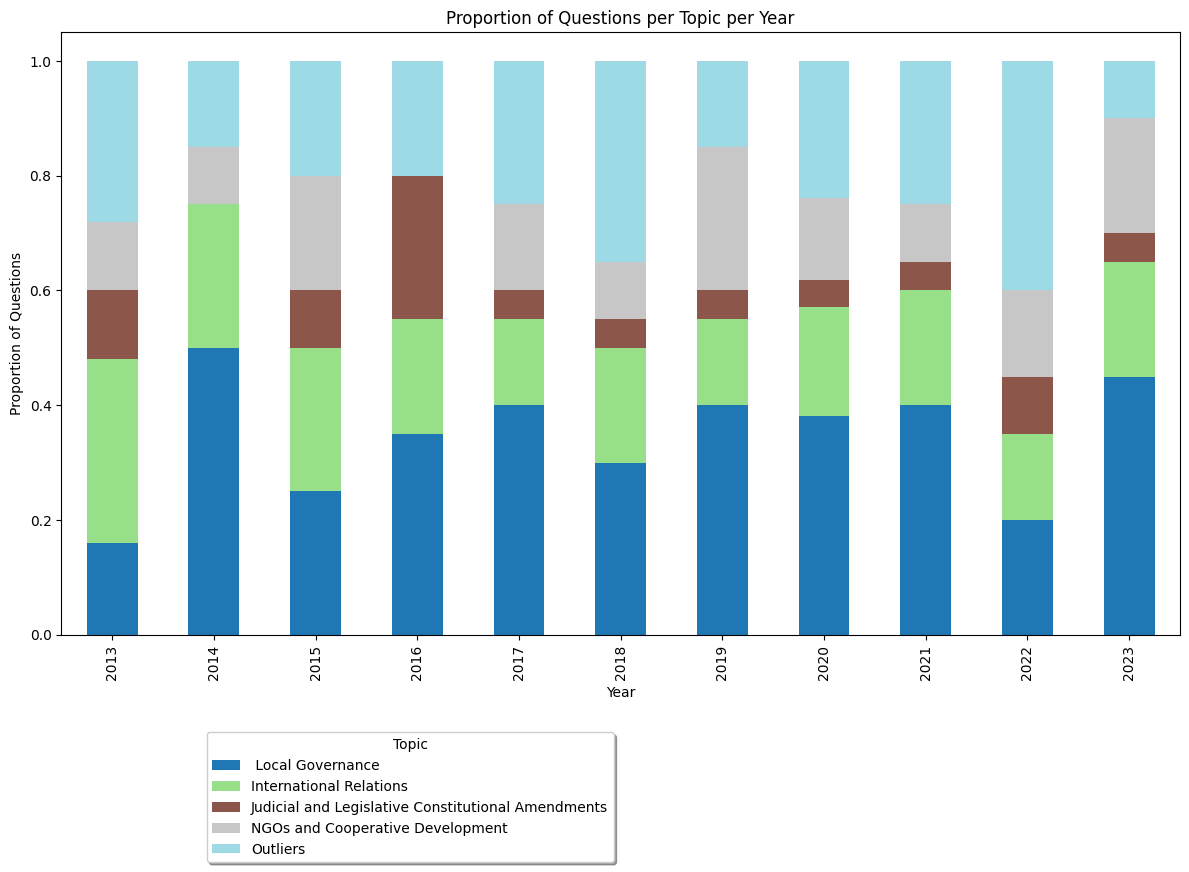

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Step 2: Count questions per topic per year
topic_year_counts = df.groupby(['Year', 'Topic']).size().reset_index(name='Count')

# Calculate the total number of questions per year
total_questions_per_year = topic_year_counts.groupby('Year')['Count'].transform('sum')

# Calculate the proportion of questions per topic per year
topic_year_counts['Proportion'] = topic_year_counts['Count'] / total_questions_per_year

# Step 3: Prepare data for plotting (normalized)
pivot_table = topic_year_counts.pivot(index='Year', columns='Topic', values='Proportion')

# Generate a list of colors from a colormap
num_topics = len(pivot_table.columns)
colors = plt.get_cmap('tab20', num_topics)

# Step 4: Plot the normalized data with different colors for each topic
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(num_topics)])

# Step 5: Customize the plot
plt.xlabel('Year')
plt.ylabel('Proportion of Questions')
plt.title('Proportion of Questions per Topic per Year')
plt.legend(title='Topic', loc='best', bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

In [19]:
model.get_representative_docs()

{-1: ['To enhance the quality of democracy in India the Election Commission of India has proposed electoral reforms in 2016. What are the suggested reforms and how far are they significant to make democracy successful?',
  'The World Bank and the IMF, collectively known as the Bretton Woods Institutions, are the two\ninter-governmental pillars supporting the structure of the world’s economic and financial order.\nSuperficially, the World Bank and the IMF exhibit many common characteristics, yet their role, functions and mandate are distinctly different.\nElucidate.',
  'Some of the International funding agencies have special terms for economic participation stipulating a substantial component of the aid to be used for sourcing equipment from the\\ leading countries.\nDiscuss on merits of such terms and if there exists a strong case not to accept such conditions in the India context.'],
 0: ['Two parallel run schemes of the Government, viz the Adhaar Card and NPR, one as voluntary and t

In [24]:
num_words = 15
topics_ = []
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        top_words = " ".join(top_words)
        topics_.append(f"Topic {topic_num}: {top_words}")

len(model.get_topics())

5

In [25]:
topics_

['Topic 0: policy how reforms in finance commission reforms about in india but are the transparency',
 'Topic 1: sri lanka lanka fdi sri wto indo asia how asian policy',
 'Topic 2: ngos poverty alleviation poverty and of ngos groups shgs the shgs poverty are alleviation programmes of poverty shgs in',
 'Topic 3: governance critically local institutions the governance governance system of governance governance government system vulnerable sections marginalised local',
 'Topic 4: constitutional amendment legislative judiciary government commission for whether how judicial the constitution']

In [26]:
topic_names = {0:'Outliers',1:'International Relations',2:'NGOs and Cooperative Development',3:'Judicial and Legislative Constitutional Amendments',4:' Local Governance'}
num_words = 10
topics_ = {}
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        topics_[topic_names[topic_num]] = top_words

In [27]:
topics_

{'Outliers': ['policy',
  'how',
  'reforms in',
  'finance commission',
  'reforms',
  'about',
  'in india',
  'but',
  'are the',
  'transparency'],
 'International Relations': ['sri lanka',
  'lanka',
  'fdi',
  'sri',
  'wto',
  'indo',
  'asia',
  'how',
  'asian',
  'policy'],
 'NGOs and Cooperative Development': ['ngos',
  'poverty alleviation',
  'poverty and',
  'of ngos',
  'groups shgs',
  'the shgs',
  'poverty are',
  'alleviation programmes',
  'of poverty',
  'shgs in'],
 'Judicial and Legislative Constitutional Amendments': ['governance critically',
  'local institutions',
  'the governance',
  'governance system',
  'of governance',
  'governance',
  'government system',
  'vulnerable sections',
  'marginalised',
  'local'],
 ' Local Governance': ['constitutional',
  'amendment',
  'legislative',
  'judiciary',
  'government',
  'commission for',
  'whether',
  'how',
  'judicial',
  'the constitution']}

In [28]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
question_embeddings = sbert_model.encode(questions)

topic_embeddings = {}
for i in range(len(topics_.items())):
    topic_embeddings[topic_names[i]] = []
    for word in topics_[topic_names[i]]:
        topic_embeddings[topic_names[i]].append(sbert_model.encode(word))
        
topic_embeddings

{'Outliers': [array([ 2.25730184e-02,  8.92232805e-02,  1.96914617e-02,  1.12280075e-03,
         -3.32629383e-02,  1.38239423e-03,  2.01674923e-02,  9.60712880e-03,
         -1.99673064e-02,  9.96988826e-03,  9.36085656e-02, -5.75105362e-02,
         -3.50395869e-03,  1.15656123e-01,  1.43908281e-02, -6.73465896e-03,
         -1.16653675e-02, -2.59200223e-02,  1.09595105e-01, -4.07633409e-02,
         -7.15851644e-03,  1.96637120e-02,  1.78863571e-04,  1.80970840e-02,
          3.26539739e-03, -2.36669555e-02,  2.28247158e-02, -2.02343576e-02,
          2.16151658e-03, -1.71450619e-03,  4.07635160e-02, -5.42951599e-02,
          2.48952992e-02, -6.54484257e-02,  2.03901550e-06, -5.11627384e-02,
          1.16486531e-02, -5.33405645e-03,  5.32276891e-02,  8.64107255e-03,
          3.62720862e-02, -4.33808519e-03, -4.46678251e-02,  1.20467907e-02,
         -6.11255281e-02,  6.25895709e-02,  4.68436256e-02, -1.89749766e-02,
          2.03442294e-02,  1.00716176e-02,  1.23473369e-02, -7.3

In [29]:
from sentence_transformers import CrossEncoder
crossencoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


In [30]:
question = questions[77]
topics_nearest = []
for i in range(len(topics_.items())):
    for word in topics_[topic_names[i]]:
        score = crossencoder.predict([(question,word)])
        topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})

topics_nearest

[{'Outliers': [-3.5129506587982178, 'policy']},
 {'Outliers': [-5.706090450286865, 'how']},
 {'Outliers': [-5.002608776092529, 'reforms in']},
 {'Outliers': [-5.677163600921631, 'finance commission']},
 {'Outliers': [-5.105074882507324, 'reforms']},
 {'Outliers': [-5.4128875732421875, 'about']},
 {'Outliers': [-4.505311012268066, 'in india']},
 {'Outliers': [-5.080244541168213, 'but']},
 {'Outliers': [-5.335608959197998, 'are the']},
 {'Outliers': [-5.447232723236084, 'transparency']},
 {'International Relations': [-6.181047439575195, 'sri lanka']},
 {'International Relations': [-6.142640590667725, 'lanka']},
 {'International Relations': [-5.404454708099365, 'fdi']},
 {'International Relations': [-5.646022796630859, 'sri']},
 {'International Relations': [-5.538663387298584, 'wto']},
 {'International Relations': [-5.466904163360596, 'indo']},
 {'International Relations': [-5.1018853187561035, 'asia']},
 {'International Relations': [-5.706090450286865, 'how']},
 {'International Relations

In [31]:
topics_nearest.sort(key=lambda x: list(x.values())[0],reverse=True)
top_7_nearest = topics_nearest[:7]
top_7_nearest

[{'Outliers': [-3.5129506587982178, 'policy']},
 {'International Relations': [-3.5129506587982178, 'policy']},
 {'Outliers': [-4.505311012268066, 'in india']},
 {' Local Governance': [-4.932835102081299, 'the constitution']},
 {'Outliers': [-5.002608776092529, 'reforms in']},
 {'Outliers': [-5.080244541168213, 'but']},
 {'Judicial and Legislative Constitutional Amendments': [-5.096804141998291,
   'the governance']}]

In [32]:
highest_scores = {}

for entry in topics_nearest:
    for topic, (score, word) in entry.items():
        if topic not in highest_scores or score > highest_scores[topic][0]:
            highest_scores[topic] = (score, word)

total = sum(score for score,word in highest_scores.values())



closest_topics = {topic:(score/total , word) for topic,(score,word) in highest_scores.items()}


closest_topics

{'Outliers': (0.15641012739334234, 'policy'),
 'International Relations': (0.15641012739334234, 'policy'),
 ' Local Governance': (0.21962886520895028, 'the constitution'),
 'Judicial and Legislative Constitutional Amendments': (0.22692939997671,
  'the governance'),
 'NGOs and Cooperative Development': (0.24062148002765502,
  'alleviation programmes')}

In [33]:
def score_generate(question):
    topics_nearest = []
    for i in range(len(topics_.items())):
        for word in topics_[topic_names[i]]:
            score = crossencoder.predict([(question,word)])
            topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})
    
    highest_scores = {}
    for entry in topics_nearest:
        for topic, (score, word) in entry.items():
            if topic not in highest_scores or score > highest_scores[topic][0]:
                highest_scores[topic] = (score, word)

    total = sum(score for score,word in highest_scores.values())
    closest_topics = {topic:(score/total) for topic,(score,word) in highest_scores.items()}
    return closest_topics

In [34]:
data = pd.DataFrame()

for i in range(len(questions)):
    data_ = pd.DataFrame(score_generate(questions[i]),index=[i])
    data_['Question'] = questions[i]
    
    data = pd.concat([data,data_],ignore_index=True)

In [35]:
data.sample(5)


,Outliers,International Relations,NGOs and Cooperative Development,Judicial and Legislative Constitutional Amendments,Local Governance,Question
139,0.122852,0.197553,0.231238,0.217622,0.230735,The question of India’s Energy Security consti...
36,0.165388,0.214131,0.207802,0.208004,0.204675,Do you agree with the view that increasing dep...
78,0.182906,0.196658,0.209438,0.203802,0.207196,‘Quadilateral Security Dialogue (Quad)’ is tra...
197,0.186523,0.204082,0.206046,0.200717,0.202633,The aim of Information Technology Agreements (...
203,0.194676,0.194676,0.203868,0.203828,0.202952,Recent directives from Ministry of Petroleum a...


In [36]:
data['Topic'] = data.iloc[:,:-1].idxmin(axis=1)
data['Year'] = df['Year']
data.sample(5)

,Outliers,International Relations,NGOs and Cooperative Development,Judicial and Legislative Constitutional Amendments,Local Governance,Question,Topic,Year
177,0.156106,0.203801,0.233318,0.182202,0.224573,Increasing interest of India in Africa has its...,Outliers,2015
129,0.202319,0.160877,0.212233,0.211466,0.213104,‘China is using its economic relations and pos...,International Relations,2017
105,0.210343,0.218076,0.173019,0.192067,0.206496,“The Comptroller and Auditor General (CAG) has...,NGOs and Cooperative Development,2018
50,0.188801,0.202598,0.203137,0.201924,0.203540,The jurisdiction of the Central Bureau of Inve...,Outliers,2021
199,0.206659,0.152781,0.220612,0.210326,0.209623,India has recently signed to become founding m...,International Relations,2014


In [37]:
data.to_excel('GS2_topics_v1.xlsx', index=False)

In [38]:
data = pd.read_excel('GS2_topics_v1.xlsx')

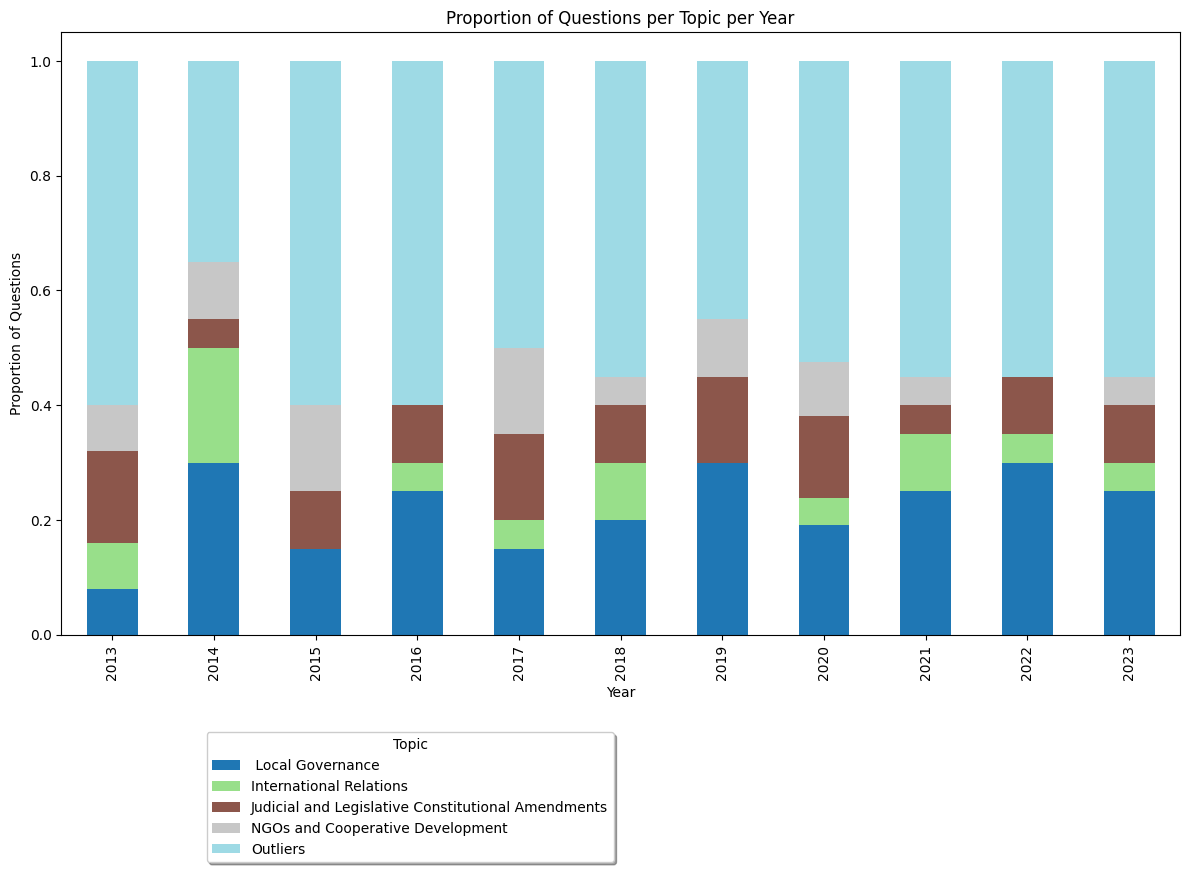

In [39]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Step 2: Count questions per topic per year
topic_year_counts = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

# Calculate the total number of questions per year
total_questions_per_year = topic_year_counts.groupby('Year')['Count'].transform('sum')

# Calculate the proportion of questions per topic per year
topic_year_counts['Proportion'] = topic_year_counts['Count'] / total_questions_per_year

# Step 3: Prepare data for plotting (normalized)
pivot_table = topic_year_counts.pivot(index='Year', columns='Topic', values='Proportion')

# Generate a list of colors from a colormap
num_topics = len(pivot_table.columns)
colors = plt.get_cmap('tab20', num_topics)

# Step 4: Plot the normalized data with different colors for each topic
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(num_topics)])

# Step 5: Customize the plot
plt.xlabel('Year')
plt.ylabel('Proportion of Questions')
plt.title('Proportion of Questions per Topic per Year')
plt.legend(title='Topic', loc='best', bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

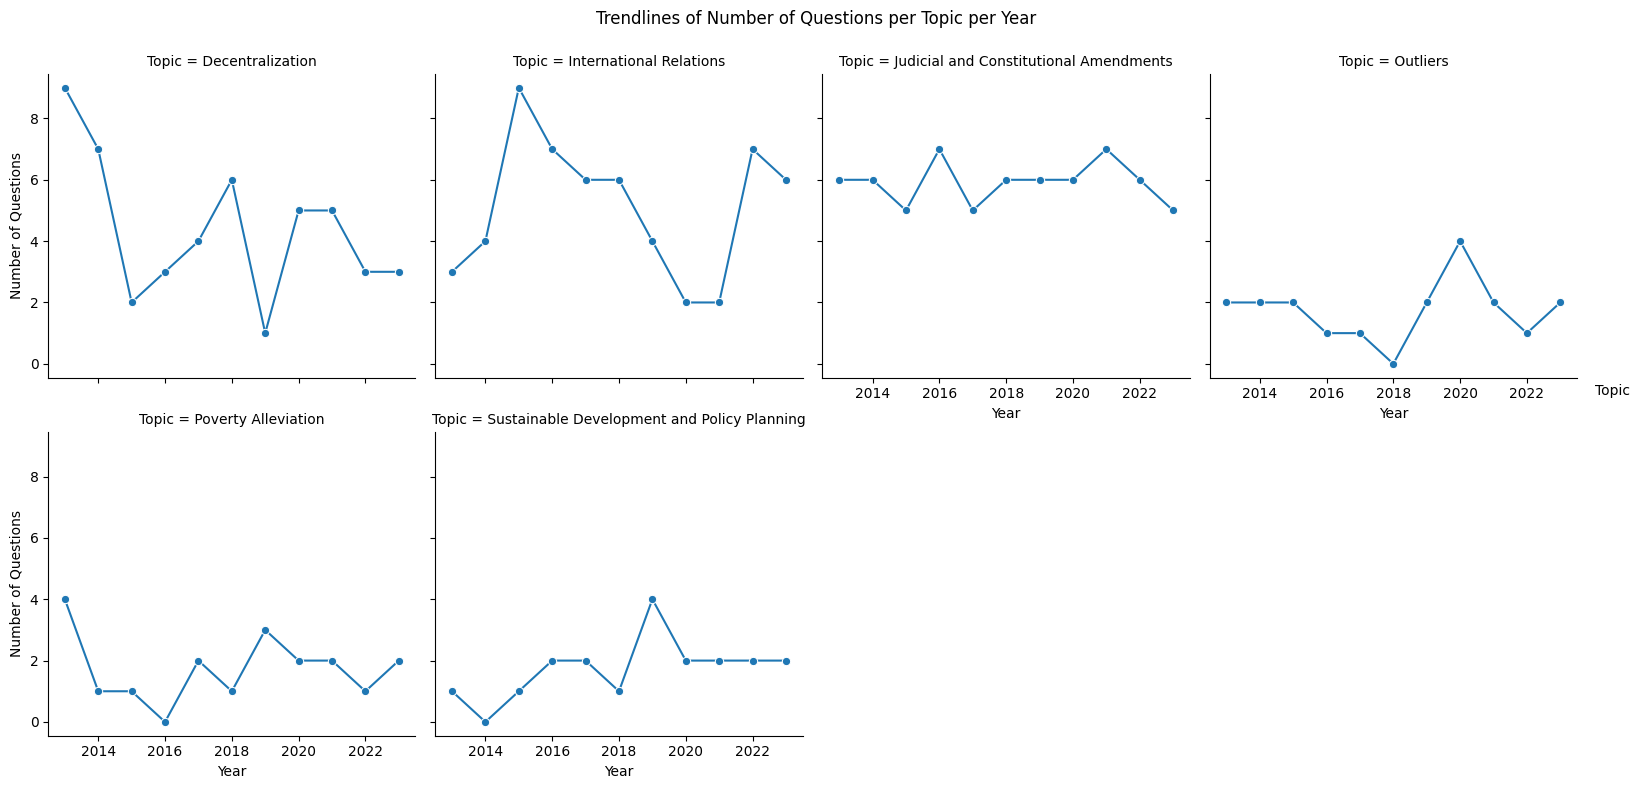

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

topic_year_counts = pd.crosstab(data['Year'], data['Topic'])

# Reset index to convert the pivot table to a DataFrame
topic_year_counts = topic_year_counts.reset_index()

# Melt the DataFrame to long format for Seaborn
melted_topic_year_counts = topic_year_counts.melt(id_vars='Year', var_name='Topic', value_name='Count')


g = sns.FacetGrid(melted_topic_year_counts, col='Topic', col_wrap=4, height=4, sharex=True, sharey=True)
g.map(sns.lineplot, 'Year', 'Count', marker='o')
g.set_axis_labels('Year', 'Number of Questions')
g.add_legend(title='Topic')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Trendlines of Number of Questions per Topic per Year')
plt.show()


<Axes: title={'center': 'Topic Frequency'}, xlabel='Topics', ylabel='Number Of Questions'>

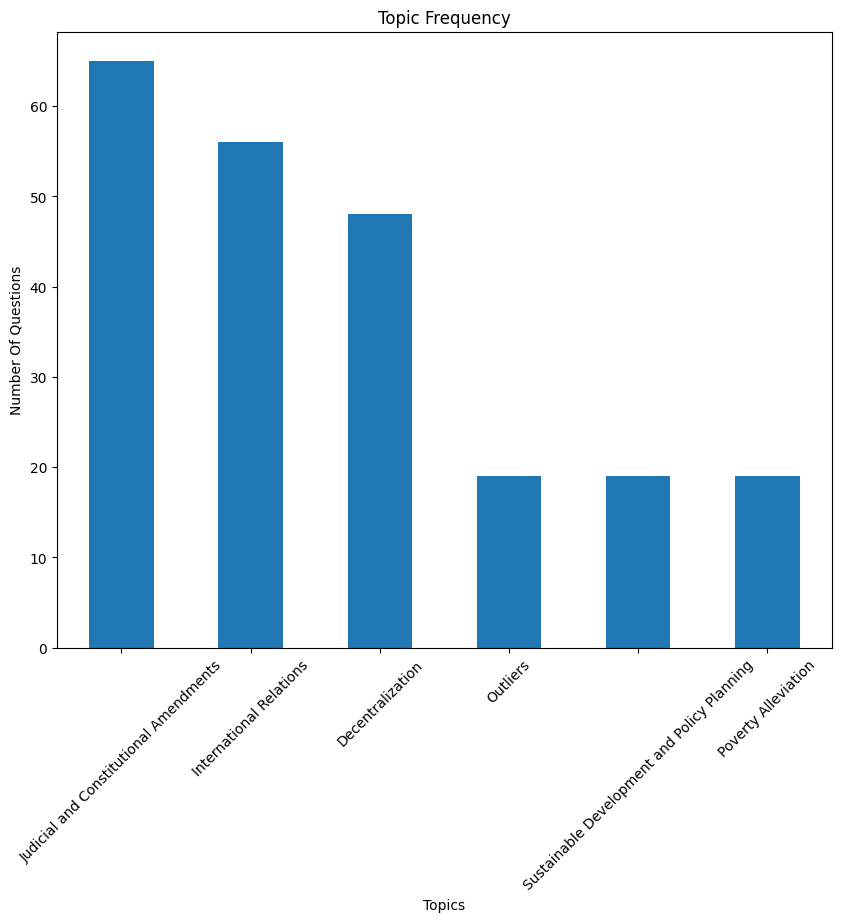

In [ ]:
data.Topic.value_counts().plot(kind='bar', figsize=(10, 8), title='Topic Frequency', xlabel='Topics', ylabel='Number Of Questions', rot=45)